# What's new in PyKE 3.1?

## Utility functions 

``PyKE`` has included two convinience functions to convert between ``module.output`` to ``channel`` and vice-versa:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pyke.utils import module_output_to_channel, channel_to_module_output

/Users/jvmirca/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
module_output_to_channel(module=19, output=3)

67

In [4]:
channel_to_module_output(67)

(19, 3)

``PyKE 3.1`` includes ``KeplerQualityFlags`` class which encodes the meaning of the Kepler QUALITY bitmask flags as documented in the Kepler Archive Manual (Table 2.3):

In [5]:
from pyke.utils import KeplerQualityFlags

In [6]:
KeplerQualityFlags.decode(1)

['Attitude tweak']

It also can handle multiple flags:

In [7]:
KeplerQualityFlags.decode(1 + 1024 + 1048576)

['Attitude tweak', 'Sudden sensitivity dropout', 'Thruster firing']

A few quality flags are already computed:

In [8]:
KeplerQualityFlags.decode(KeplerQualityFlags.DEFAULT_BITMASK)

['Attitude tweak',
 'Safe mode',
 'Coarse point',
 'Earth point',
 'Desaturation event',
 'Cosmic ray in optimal aperture',
 'Manual exclude',
 'No data',
 'Thruster firing']

In [9]:
KeplerQualityFlags.decode(KeplerQualityFlags.CONSERVATIVE_BITMASK)

['Attitude tweak',
 'Safe mode',
 'Coarse point',
 'Earth point',
 'Desaturation event',
 'Cosmic ray in optimal aperture',
 'Manual exclude',
 'Sudden sensitivity dropout',
 'Cosmic ray in collateral data',
 'No data',
 'Possible thruster firing',
 'Thruster firing']

## Target Pixel File (TPF)

`PyKE 3.1` includes class called ``KeplerTargetPixelFile`` which is used to handle target pixel files:

In [10]:
from pyke import KeplerTargetPixelFile

A `KeplerTargetPixelFile` can be instantiated either from a local file or a url:

In [11]:
tpf = KeplerTargetPixelFile('https://archive.stsci.edu/missions/k2/target_pixel_files/c14/'
                            '200100000/82000/ktwo200182949-c14_lpd-targ.fits.gz')

Additionally, we can mask out cadences that are flagged using the `quality_bitmask` argument in the constructor:

In [12]:
tpf = KeplerTargetPixelFile('https://archive.stsci.edu/missions/k2/target_pixel_files/c14/'
                            '200100000/82000/ktwo200182949-c14_lpd-targ.fits.gz',
                            quality_bitmask=KeplerQualityFlags.CONSERVATIVE_BITMASK)

Furthermore, we can mask out pixel values using the `aperture_mask` argument. The default behaviour is to use
all pixels that have real values. This argument can also get a string value `'kepler-pipeline'`, in which case the default aperture used by Kepler's pipeline is applied.

In [13]:
tpf = KeplerTargetPixelFile('https://archive.stsci.edu/missions/k2/target_pixel_files/c14/'
                            '200100000/82000/ktwo200182949-c14_lpd-targ.fits.gz',
                            aperture_mask='kepler-pipeline',
                            quality_bitmask=KeplerQualityFlags.CONSERVATIVE_BITMASK)

In [14]:
tpf.aperture_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

The TPF objects stores both data and a few metadata information, e.g., channel number, EPIC number, reference column and row, module, and shape. The whole `header` is also available:

In [15]:
tpf.header(ext=0)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2017-10-30'         / file creation date.                            
CREATOR = '472097 TargetPixelExporterPipelineModule' / pipeline job and program 
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.75 r62933' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

The pixel fluxes time series can be accessed using the ``flux`` property:

In [16]:
tpf.flux.shape

(3209, 35, 35)

This shows that our TPF is a 35 x 35 image recorded over 3209 cadences.

One can visualize the pixel data at a given cadence using the ``plot`` method:

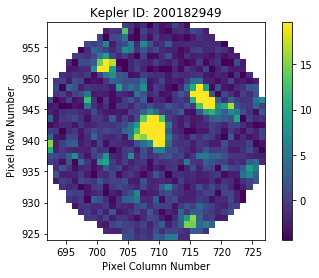

In [17]:
tpf.plot(frame=1)

We can perform aperture photometry using the method ``to_lightcurve``:

In [18]:
lc = tpf.to_lightcurve()

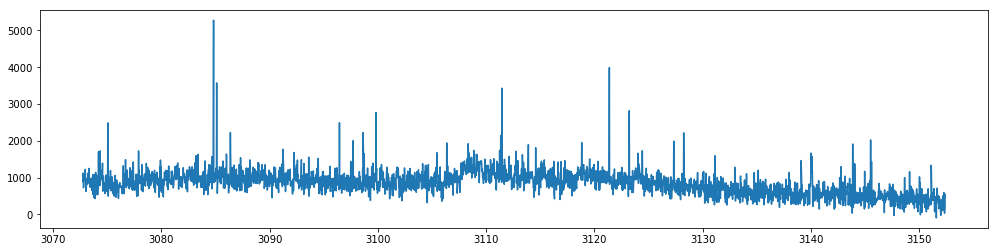

In [19]:
plt.figure(figsize=[17, 4])
plt.plot(lc.time, lc.flux)

## Light Curves

Let's see how the previous light curve compares against the ``'SAP_FLUX'`` produced by Kepler's pipeline. For that, we are going to explore the ``KeplerLightCurveFile`` class:

In [20]:
from pyke.lightcurve import KeplerLightCurveFile

In [21]:
klc = KeplerLightCurveFile('https://archive.stsci.edu/missions/k2/lightcurves/'
                           'c14/200100000/82000/ktwo200182949-c14_llc.fits',
                           quality_bitmask=KeplerQualityFlags.CONSERVATIVE_BITMASK)

In [22]:
sap_lc = klc.SAP_FLUX

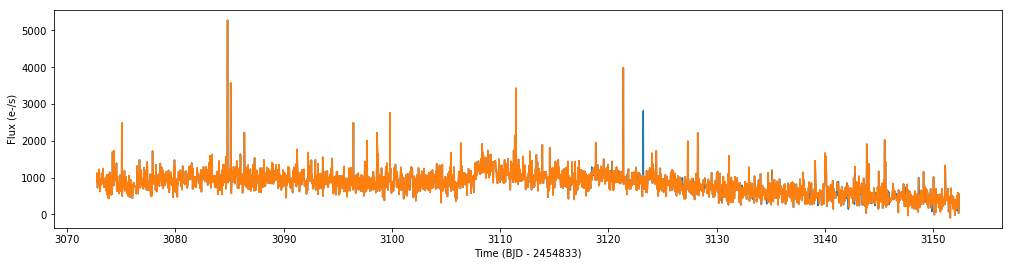

In [23]:
plt.figure(figsize=[17, 4])
plt.plot(lc.time, lc.flux)
plt.plot(sap_lc.time, sap_lc.flux)
plt.ylabel('Flux (e-/s)')
plt.xlabel('Time (BJD - 2454833)')

Now, let's correct this light curve using by fitting cotrending basis vectors. That can be achived either with the ``KeplerCBVCorrector`` class or the ``compute_cotrended_lightcurve`` in ``KeplerLightCurveFile``. Let's try the latter:

In [24]:
klc_corrected = klc.compute_cotrended_lightcurve(cbvs=range(1, 17))

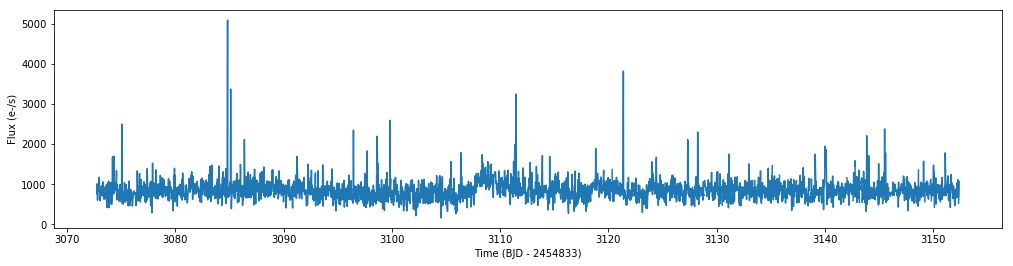

In [25]:
plt.figure(figsize=[17, 4])
plt.plot(klc_corrected.time, klc_corrected.flux)
plt.ylabel('Flux (e-/s)')
plt.xlabel('Time (BJD - 2454833)')

In [26]:
pdcsap_lc = klc.PDCSAP_FLUX

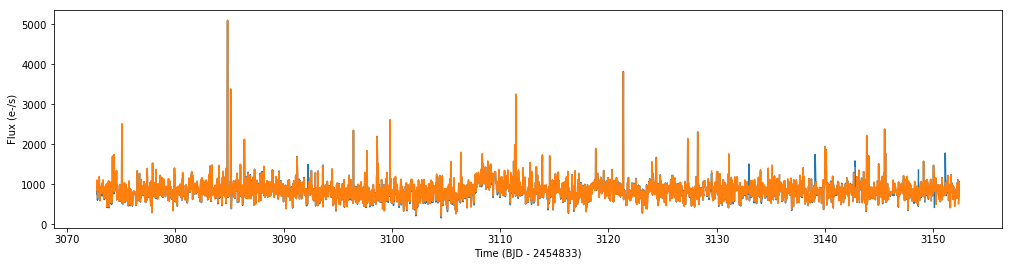

In [27]:
plt.figure(figsize=[17, 4])
plt.plot(klc_corrected.time, klc_corrected.flux)
plt.plot(pdcsap_lc.time, pdcsap_lc.flux)
plt.ylabel('Flux (e-/s)')
plt.xlabel('Time (BJD - 2454833)')

## Pixel Response Function (PRF) Photometry

`PyKE 3.1` also includes tools to perform PRF Photometry:

In [28]:
from pyke.prf import PRFPhotometry, SceneModel, SimpleKeplerPRF

For that, let's create a ``SceneModel`` which will be fitted to the object of the following TPF:

In [29]:
tpf = KeplerTargetPixelFile('https://archive.stsci.edu/missions/k2/target_pixel_files/c14/'
                            '201500000/43000/ktwo201543306-c14_lpd-targ.fits.gz',
                            quality_bitmask=KeplerQualityFlags.CONSERVATIVE_BITMASK)

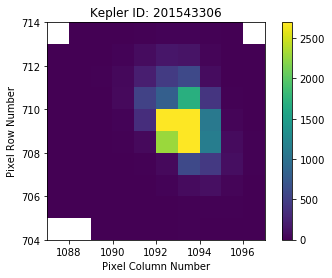

In [30]:
tpf.plot(frame=100)

In [31]:
scene = SceneModel(prfs=[SimpleKeplerPRF(channel=tpf.channel, shape=tpf.shape[1:],
                                         column=tpf.column, row=tpf.row)])

We also need to define prior distributions on the parameters of our ``SceneModel`` model. Those parameters are
the flux, center positions of the target, and a constant background level. We can do that with ``oktopus``:

In [32]:
from oktopus.prior import UniformPrior

In [33]:
unif_prior = UniformPrior(lb=[0, 1090., 706., 0.],
                          ub=[1e5, 1096., 712., 1e5])

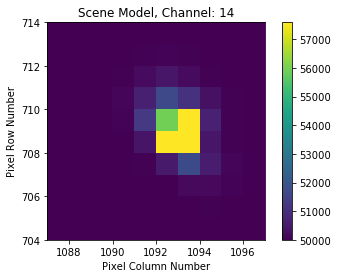

In [34]:
scene.plot(*unif_prior.mean)

In [35]:
prf_phot = PRFPhotometry(scene_model=scene, prior=unif_prior)

In [36]:
results = prf_phot.fit(tpf.flux + tpf.flux_bkg)

  0%|          | 0/3633 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/autograd/core.py:82: RuntimeWarning: invalid value encountered in log
  result_value = self.fun(*argvals, **kwargs)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1929: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
100%|██████████| 3633/3633 [02:49<00:00, 21.46it/s]


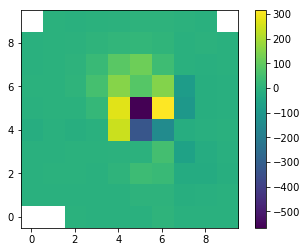

In [37]:
plt.imshow(prf_phot.residuals[1], origin='lower')
plt.colorbar()

In [38]:
flux = results[:, 0]
xcenter = results[:, 1]
ycenter = results[:, 2]
bkg_density = results[:, 3]

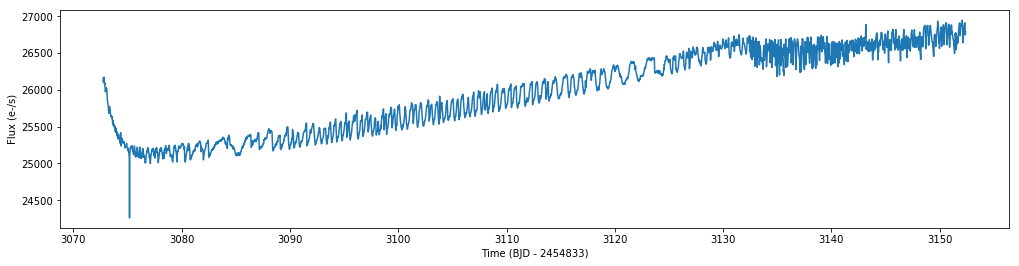

In [39]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux)
plt.ylabel('Flux (e-/s)')
plt.xlabel('Time (BJD - 2454833)')

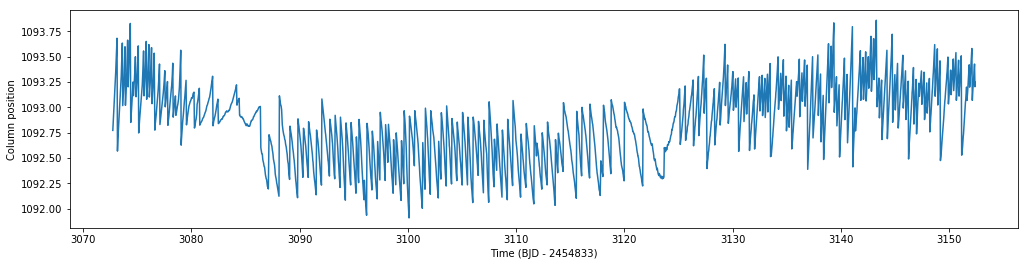

In [40]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, xcenter)
plt.ylabel('Column position')
plt.xlabel('Time (BJD - 2454833)')

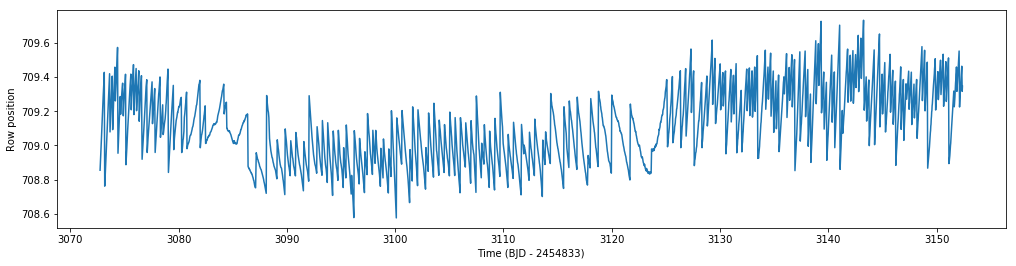

In [41]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, ycenter)
plt.ylabel('Row position')
plt.xlabel('Time (BJD - 2454833)')

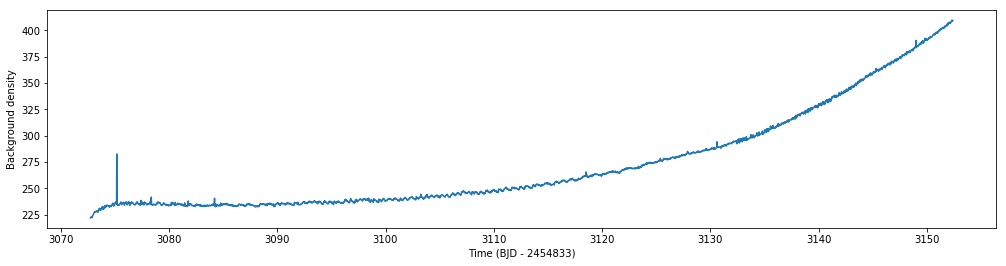

In [42]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, bkg_density)
plt.ylabel('Background density')
plt.xlabel('Time (BJD - 2454833)')

For more examples on PRF photometry, please see our tutorials page: http://pyke.keplerscience.org/tutorials/index.html